# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [51]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
seed = 0

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

scaler = StandardScaler()
X = scaler.fit_transform(X)

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [52]:
(X_train.shape, X_test.shape)

((1483, 10), (371, 10))

In [53]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

1. ¿De qué se trata el conjunto de datos?

El *dataset* contiene un conjunto de datos que describen el comportamiento crediticio histórico de los clientes de un banco que hayan solicitado presetamos recientes.

2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo `TARGET` se trata de una variable binaria que puede asumir el valor 1, si el cliente no pagó el credito solicitado, y 0 caso contrario.


3. ¿Qué información (atributos) hay disponible para hacer la predicción?

- LOAN    Monto de préstamo requerido.
- MORTDUE Saldo de crédito hipotecario existente.
- VALUE   Valor actual de la propiedad.
- YOJ     Años en el trabajo actual.
- DEROG   Número de informes despectivos.
- DELINQ  Número de créditos en estado moroso.
- CLAGE   Linea de crédito más antigua en meses.
- NINQ    Número reciente de lineas de crédito.
- CLNO    Número de lineas de crédito.
- DEBTINC Cociente de deuda e ingresos.

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

. LOAN
. DELINQ
. DEBTINC
. DEROG

## Análisis de la variable `TARGET`

In [54]:
dataset["TARGET"].value_counts()
nof_targets_train = len(y_train)
nof_ones_train = np.sum(y_train == 1)
nof_zeros_train = np.sum(y_train == 0)

nof_targets_test = len(y_test)
nof_ones_test = np.sum(y_test == 1)
nof_zeros_test = np.sum(y_test == 0)

(nof_ones_train / nof_targets_train, nof_ones_test / nof_targets_test)

(0.16925151719487525, 0.15633423180592992)

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [56]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [57]:
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       313
           1       0.62      0.28      0.38        58

    accuracy                           0.86       371
   macro avg       0.75      0.62      0.65       371
weighted avg       0.84      0.86      0.84       371



- 0 (N): Pagó el prestamo.
- 1 (P): No pagó el prestamo.
- TP: Casos predichos que no pagarón y no pagaron efectivamente.
- TF: Casos predichos que pagaron y pagaron efectivamente.
- FP: Casos predichos que P (No pagó el prestamo) y pasó N (Pagó el prestamo).
- FN: Casos predichos que N (Pagó el prestamo) y pasó P (No pagó el prestamo).

- Recall: TP / (TP + FN)
- Precision: TP / (TP + FP)
- F1-score : 2*(Precision*Recall/Precision + Recall)

Preferimos no tener FN a costa de algunos FP.

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(303, 10, 42, 16)

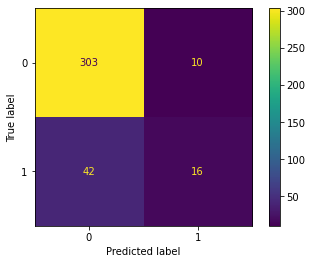

In [61]:
plot_confusion_matrix(clf, X_test, y_test)

In [62]:
clf.coef_.shape

(1, 10)

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [75]:
from sklearn.model_selection import GridSearchCV

# TODO: Check other params
param_grid = {
    'loss': ['hinge','log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2','l1']  
}

model = SGDClassifier()
cv = GridSearchCV(model, param_grid, scoring=["recall", "accuracy", "precision", "f1"], cv=5, refit=False)
cv.fit(X, y)

results = cv.cv_results_
params = results['params']

/home/benjamin/miniconda3/envs/diplodatos-introml/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/benjamin/miniconda3/envs/diplodatos-introml/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/benjamin/miniconda3/envs/diplodatos-introml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/benjamin/miniconda3/envs/diplodatos

In [76]:
results_df = pd.DataFrame(results)
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_loss', 'param_penalty', 'params',
       'split0_test_recall', 'split1_test_recall', 'split2_test_recall',
       'split3_test_recall', 'split4_test_recall', 'mean_test_recall',
       'std_test_recall', 'rank_test_recall', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [77]:
results_df[["param_alpha", "param_loss", "param_penalty",
            "mean_test_recall", "std_test_recall",
            "mean_test_accuracy", "std_test_accuracy",
            "mean_test_precision", "std_test_precision",
            "rank_test_recall"]].sort_values(by="rank_test_recall")

,param_alpha,param_loss,param_penalty,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,rank_test_recall
48,0.1,perceptron,l2,0.507403,0.111129,0.802056,0.015790,0.422108,0.029756,1
18,0.0001,perceptron,l2,0.442887,0.168812,0.805299,0.067199,0.473997,0.170153,2
38,0.01,perceptron,l2,0.436277,0.143566,0.810145,0.022808,0.434016,0.046238,3
10,0.0001,hinge,l2,0.429984,0.167337,0.848445,0.039927,0.605196,0.130070,4
15,0.0001,modified_huber,l1,0.429773,0.102380,0.806929,0.082851,0.529026,0.207343,5
16,0.0001,squared_hinge,l2,0.416605,0.163828,0.774510,0.046956,0.365671,0.135460,6
2,0.00001,log,l2,0.397515,0.145408,0.811755,0.044645,0.441848,0.129296,7
39,0.01,perceptron,l1,0.385563,0.171549,0.774452,0.089879,0.479405,0.210958,8
4,0.00001,modified_huber,l2,0.378265,0.108766,0.798241,0.046413,0.420193,0.118232,9
28,0.001,perceptron,l2,0.378160,0.088615,0.817704,0.035154,0.466157,0.104415,10


## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html